In [4]:
import math
import numpy as np
import random as rnd
import tensorflow as tf

%matplotlib inline
from matplotlib import pyplot as plt

In [12]:
class SOM(object):
    """
    2-D Self-Organizing Map with Gaussian Neighbourhood function
    and linearly decreasing learning rate.
    """
 
    #To check if the SOM has been trained
    _trained = False
 
    def __init__(self, m, n, dim, n_iterations=100, alpha=None, sigma=None):
        """
        Initializes all necessary components of the TensorFlow
        Graph.
 
        m X n are the dimensions of the SOM. 'n_iterations' should
        should be an integer denoting the number of iterations undergone
        while training.
        'dim' is the dimensionality of the training inputs.
        'alpha' is a number denoting the initial time(iteration no)-based
        learning rate. Default value is 0.3
        'sigma' is the the initial neighbourhood value, denoting
        the radius of influence of the BMU while training. By default, its
        taken to be half of max(m, n).
        """
 
        # Assign required variables first
        self._m = m
        self._n = n
        if alpha is None:
            alpha = 0.3
        else:
            alpha = float(alpha)
        if sigma is None:
            sigma = max(m, n) / 2.0
        else:
            sigma = float(sigma)
        self._n_iterations = abs(int(n_iterations))
 
        ## INITIALIZE GRAPH
        self._graph = tf.Graph()
 
        ## POPULATE GRAPH WITH NECESSARY COMPONENTS
        with self._graph.as_default():
 
            ## VARIABLES AND CONSTANT OPS FOR DATA STORAGE
            
            # Randomly initialized weightage vectors for all neurons,
            # stored together as a matrix Variable of size [m*n, dim]
            self._weightage_vects = tf.Variable(tf.random_normal([m*n, dim]))
 
            # Matrix of size [m*n, 2] for SOM grid locations of neurons
            self._location_vects = tf.constant(np.array(list(self._neuron_locations(m, n))))
 
            ## PLACEHOLDERS FOR TRAINING INPUTS
            # We need to assign them as attributes to self, since they
            # will be fed in during training
 
            # The training vector
            self._vect_input = tf.placeholder("float", [dim])
            # Iteration number
            self._iter_input = tf.placeholder("float")
 
            ## CONSTRUCT TRAINING OP PIECE BY PIECE
            # Only the final, 'root' training op needs to be assigned as
            # an attribute to self, since all the rest will be executed
            # automatically during training
 
            # To compute the Best Matching Unit given a vector
            # Basically calculates the Euclidean distance between every
            # neuron's weightage vector and the input, and returns the
            # index of the neuron which gives the least value
            bmu_index = tf.argmin(tf.sqrt(tf.reduce_sum(
                tf.pow(tf.subtract(self._weightage_vects, 
                                   tf.stack([self._vect_input for i in range(m*n)])), 2), 1)), 0)
 
            # This will extract the location of the BMU based on the BMU's
            # index
            slice_input = tf.pad(tf.reshape(bmu_index, [1]), np.array([[0, 1]]))
#             print('slice_input =', slice_input, type(slice_input))
            bmu_loc = tf.reshape(tf.slice(self._location_vects, slice_input, [1, 2]), [2])
 
            # To compute the alpha and sigma values based on iteration
            # number
            learning_rate_op = tf.subtract(1.0, tf.div(self._iter_input, self._n_iterations))
            _alpha_op = tf.multiply(alpha, learning_rate_op)
            _sigma_op = tf.multiply(sigma, learning_rate_op)
 
            # Construct the op that will generate a vector with learning
            # rates for all neurons, based on iteration number and location
            # w.r.t. BMU.
            bmu_distance_squares = tf.reduce_sum(tf.pow(tf.subtract(
                self._location_vects, tf.stack([bmu_loc for i in range(m*n)])), 2), 1)
            neighbourhood_func = tf.exp(tf.negative(
                tf.divide(tf.cast(bmu_distance_squares, "float32"), tf.pow(_sigma_op, 2))))
            learning_rate_op = tf.multiply(_alpha_op, neighbourhood_func)
 
            # Finally, the op that will use learning_rate_op to update
            # the weightage vectors of all neurons based on a particular
            # input
            learning_rate_multiplier = tf.stack([tf.tile(tf.slice(
                learning_rate_op, np.array([i]), np.array([1])), [dim])
                                               for i in range(m*n)])
            weightage_delta = tf.multiply(
                learning_rate_multiplier,
                tf.subtract(tf.stack([self._vect_input for i in range(m*n)]),
                       self._weightage_vects))                                         
            new_weightages_op = tf.add(self._weightage_vects,
                                       weightage_delta)
            self._training_op = tf.assign(self._weightage_vects,
                                          new_weightages_op)                                       
 
            ##INITIALIZE SESSION
            self._sess = tf.Session()
 
            ##INITIALIZE VARIABLES
            init_op = tf.global_variables_initializer()
            self._sess.run(init_op)
 
    def _neuron_locations(self, m, n):
        """
        Yields one by one the 2-D locations of the individual neurons
        in the SOM.
        """
        #Nested iterations over both dimensions
        #to generate all 2-D locations in the map
        for i in range(m):
            for j in range(n):
                yield np.array([i, j])
 
    def train(self, input_vects):
        """
        Trains the SOM.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Current weightage vectors for all neurons(initially random) are
        taken as starting conditions for training.
        """
 
        #Training iterations
        for iter_no in range(self._n_iterations):
            #Train with each vector one by one
            counter = 0
            for input_vect in input_vects:
                self._sess.run(self._training_op,
                               feed_dict={self._vect_input: input_vect,
                                          self._iter_input: iter_no})
                counter += 1
                if counter % 1000 == 0:
                    print('training iteration:', iter_no, 'iter_no:', counter)
 
        #Store a centroid grid for easy retrieval later on
        centroid_grid = [[] for i in range(self._m)]
        self._weightages = list(self._sess.run(self._weightage_vects))
        self._locations = list(self._sess.run(self._location_vects))
        for i, loc in enumerate(self._locations):
            centroid_grid[loc[0]].append(self._weightages[i])
        self._centroid_grid = centroid_grid
 
        self._trained = True
 
    def get_centroids(self):
        """
        Returns a list of 'm' lists, with each inner list containing
        the 'n' corresponding centroid locations as 1-D NumPy arrays.
        """
        if not self._trained:
            raise ValueError("SOM not trained yet")
        return self._centroid_grid
 
    def map_vects(self, input_vects):
        """
        Maps each input vector to the relevant neuron in the SOM
        grid.
        'input_vects' should be an iterable of 1-D NumPy arrays with
        dimensionality as provided during initialization of this SOM.
        Returns a list of 1-D NumPy arrays containing (row, column)
        info for each input vector(in the same order), corresponding
        to mapped neuron.
        """
 
        if not self._trained:
            raise ValueError("SOM not trained yet")
 
        to_return = []
        for vect in input_vects:
            min_index = min([i for i in range(len(self._weightages))],
                            key=lambda x: np.linalg.norm(vect-
                                                         self._weightages[x]))
            to_return.append(self._locations[min_index])
 
        return to_return

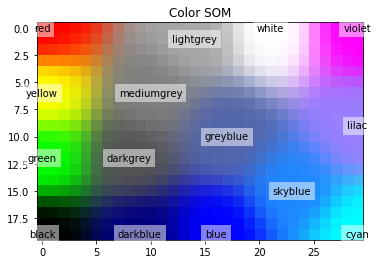

In [10]:
#Training inputs for RGBcolors
colors = np.array(
     [[0., 0., 0.],
      [0., 0., 1.],
      [0., 0., 0.5],
      [0.125, 0.529, 1.0],
      [0.33, 0.4, 0.67],
      [0.6, 0.5, 1.0],
      [0., 1., 0.],
      [1., 0., 0.],
      [0., 1., 1.],
      [1., 0., 1.],
      [1., 1., 0.],
      [1., 1., 1.],
      [.33, .33, .33],
      [.5, .5, .5],
      [.66, .66, .66]])
color_names = \
    ['black', 'blue', 'darkblue', 'skyblue',
     'greyblue', 'lilac', 'green', 'red',
     'cyan', 'violet', 'yellow', 'white',
     'darkgrey', 'mediumgrey', 'lightgrey']
 
#Train a 20x30 SOM with 400 iterations
som = SOM(20, 30, 3, 400)
som.train(colors)
 
#Get output grid
image_grid = som.get_centroids()
 
#Map colours to their closest neurons
mapped = som.map_vects(colors)
 
#Plot
plt.imshow(image_grid)
plt.title('Color SOM')
for i, m in enumerate(mapped):
    plt.text(m[1], m[0], color_names[i], ha='center', va='center',
             bbox=dict(facecolor='white', alpha=0.5, lw=0))
plt.show()

In [13]:
#Training inputs for RGBcolors
train_images_1_z = np.load('model/train_images_1_z.npy')
 
#Train a 40x40 SOM with 10 iterations
som = SOM(40, 40, 640, 10)
som.train(train_images_1_z)
 
# #Get output grid
# image_grid = som.get_centroids()
 
# #Map colours to their closest neurons
# mapped = som.map_vects(colors)
 
# #Plot
# plt.imshow(image_grid)
# plt.title('Color SOM')
# for i, m in enumerate(mapped):
#     plt.text(m[1], m[0], color_names[i], ha='center', va='center',
#              bbox=dict(facecolor='white', alpha=0.5, lw=0))
# plt.show()

training iteration: 0 iter_no: 1000
training iteration: 0 iter_no: 2000
training iteration: 0 iter_no: 3000
training iteration: 0 iter_no: 4000
training iteration: 0 iter_no: 5000
training iteration: 0 iter_no: 6000
training iteration: 0 iter_no: 7000
training iteration: 0 iter_no: 8000
training iteration: 0 iter_no: 9000
training iteration: 0 iter_no: 10000
training iteration: 0 iter_no: 11000
training iteration: 0 iter_no: 12000
training iteration: 0 iter_no: 13000
training iteration: 0 iter_no: 14000
training iteration: 0 iter_no: 15000
training iteration: 0 iter_no: 16000
training iteration: 0 iter_no: 17000
training iteration: 0 iter_no: 18000
training iteration: 0 iter_no: 19000
training iteration: 0 iter_no: 20000
training iteration: 0 iter_no: 21000
training iteration: 0 iter_no: 22000
training iteration: 0 iter_no: 23000
training iteration: 0 iter_no: 24000
training iteration: 0 iter_no: 25000
training iteration: 0 iter_no: 26000
training iteration: 0 iter_no: 27000
training i

training iteration: 5 iter_no: 24000
training iteration: 5 iter_no: 25000
training iteration: 5 iter_no: 26000
training iteration: 5 iter_no: 27000
training iteration: 5 iter_no: 28000
training iteration: 5 iter_no: 29000
training iteration: 5 iter_no: 30000
training iteration: 5 iter_no: 31000
training iteration: 5 iter_no: 32000
training iteration: 5 iter_no: 33000
training iteration: 5 iter_no: 34000
training iteration: 5 iter_no: 35000
training iteration: 5 iter_no: 36000
training iteration: 5 iter_no: 37000
training iteration: 5 iter_no: 38000
training iteration: 5 iter_no: 39000
training iteration: 5 iter_no: 40000
training iteration: 6 iter_no: 1000
training iteration: 6 iter_no: 2000
training iteration: 6 iter_no: 3000
training iteration: 6 iter_no: 4000
training iteration: 6 iter_no: 5000
training iteration: 6 iter_no: 6000
training iteration: 6 iter_no: 7000
training iteration: 6 iter_no: 8000
training iteration: 6 iter_no: 9000
training iteration: 6 iter_no: 10000
training i

In [15]:
som_weight_grid = som.get_centroids()
som_weight_grid = np.asarray(som_weight_grid)
print('som_weight_grid:', som_weight_grid.shape)
np.save('model/som_weight_grid.npy', som_weight_grid)

som_weight_grid: (40, 40, 640)


In [2]:
# %%
# load training image_1, training cmd_1, and training images_1_z
train_images_1 = np.load('train_images.npy')
train_cmds_1 = np.load("train_cmds.npy")
train_steps_1 = train_cmds_1[:, 0]
train_angles_1 = train_cmds_1[:, 1]
train_images_1_z = np.load('model/train_images_1_z.npy')
print(train_images_1.shape, train_cmds_1.shape, train_steps_1.shape, train_angles_1.shape, train_images_1_z.shape)

# load training image_2, training cmd_2, and and training images_2_z
train_images_2 = np.load('train_images2.npy')
train_cmds_2 = np.load("train_cmds2.npy")
train_steps_2 = train_cmds_2[:, 0]
train_angles_2 = train_cmds_2[:, 1]
train_images_2_z = np.load('model/train_images_2_z.npy')
print(train_images_2.shape, train_cmds_2.shape, train_steps_2.shape, train_angles_2.shape, train_images_2_z.shape)

# load test images, related commands and test images_z
test_images = np.load('test_images.npy')
test_cmds = np.load('test_cmds.npy')
test_xs = test_cmds[:, 0]
test_x_set = set(test_xs)
test_ys = test_cmds[:, 1]
test_y_set = set(test_ys)
test_angles = test_cmds[:, 2]
test_angle_set = set(test_angles)
test_images_z = np.load('model/test_images_z.npy')
print(test_images.shape, test_cmds.shape, test_xs.shape, len(test_x_set), test_ys.shape, len(test_y_set),
      test_angles.shape, len(test_angle_set), test_images_z.shape)
# print(test_x_set, test_y_set, test_angle_set)

(40000, 40, 320, 1) (39999, 3) (39999,) (39999,)
(40000, 40, 320, 1) (39999, 3) (39999,) (39999,)
(12096, 40, 320, 1) (12096, 3) (12096,) 24 (12096,) 14 (12096,) 36 (12096, 640)


In [6]:
import datetime

def find_best_match(image_list_z, max_idx, find_image_z):
    end_idx = min(image_list_z.shape[0], max_idx)
    distance_val = math.inf
    min_idx = -1
    for idx in range(end_idx):
        score = np.sum(np.power(np.subtract(image_list_z[idx, :], find_image_z), 2))
        if score < distance_val:
            min_idx = idx
            distance_val = score
    return min_idx, distance_val

head_cell_counter = 0
image_head_map = np.zeros((train_images_1_z.shape[0], 1))*-1
head_image_map = {}

place_cell_counter = 0
image_place_map = np.zeros((train_images_1_z.shape[0], 1))*-1
place_image_map = {}

for idx in range(train_images_1_z.shape[0]):
    if idx % 100 == 0:
        print(datetime.datetime.now(), ':', idx)
    if idx == 0:
        image_head_map[idx, 0] = head_cell_counter
        head_image_map[head_cell_counter] = [idx]
        head_cell_counter += 1
        image_place_map[idx, 0] = place_cell_counter
        place_image_map[place_cell_counter] = [idx]
        place_cell_counter += 1
    else:
        train_step = train_steps_1[idx-1]
        train_angle = train_angles_1[idx-1]
        find_image_z = train_images_1_z[idx]
        if train_angle != 0:
            # find a best match head direction cell or add a new one
            best_match_idx, best_match_score = find_best_match(train_images_1_z, idx, find_image_z)
            if best_match_score < 20:
                head_cell_idx = image_head_map[best_match_idx, 0]
                image_head_map[idx, 0] = head_cell_idx
                image_list = head_image_map[head_cell_idx]
                image_list.append(idx)
                head_image_map[head_cell_idx] = image_list
            else:
                image_head_map[idx, 0] = head_cell_counter
                head_image_map[head_cell_counter] = [idx]
                head_cell_counter += 1
            # set the place cell the same as the previous image
            place_cell_idx = image_place_map[idx-1, 0]
            image_place_map[idx, 0] = place_cell_idx
            image_list = place_image_map[place_cell_idx]
            image_list.append(idx)
            place_image_map[place_cell_idx] = image_list
        elif train_step != 0:
            # find a best match place cell or add a new one
            best_match_idx, best_match_score = find_best_match(train_images_1_z, idx, find_image_z)
            if best_match_score < 20:
                place_cell_idx = image_place_map[best_match_idx, 0]
                image_place_map[idx, 0] = place_cell_idx
                image_list = place_image_map[place_cell_idx]
                image_list.append(idx)
                place_image_map[place_cell_idx] = image_list
            else:
                image_place_map[idx, 0] = place_cell_counter
                place_image_map[place_cell_counter] = [idx]
                place_cell_counter += 1
            # set the head direction cell the same as the previous image
            head_cell_idx = image_head_map[idx-1, 0]
            image_head_map[idx, 0] = head_cell_idx
            image_list = head_image_map[head_cell_idx]
            image_list.append(idx)
            head_image_map[head_cell_idx] = image_list
        else:
            print('ERROR!!!')
            
print('head_cell', head_cell_counter, 'place_cell', place_cell_counter)

2018-02-25 12:38:49.922900 : 0
2018-02-25 12:38:50.104528 : 100
2018-02-25 12:38:50.602903 : 200
2018-02-25 12:38:51.364924 : 300
2018-02-25 12:38:52.523248 : 400
2018-02-25 12:38:53.902729 : 500
2018-02-25 12:38:55.615466 : 600
2018-02-25 12:38:57.628115 : 700
2018-02-25 12:38:59.788672 : 800
2018-02-25 12:39:02.140824 : 900
2018-02-25 12:39:04.747676 : 1000
2018-02-25 12:39:07.616715 : 1100
2018-02-25 12:39:11.112200 : 1200
2018-02-25 12:39:14.525647 : 1300
2018-02-25 12:39:18.217253 : 1400
2018-02-25 12:39:22.177637 : 1500
2018-02-25 12:39:26.429160 : 1600
2018-02-25 12:39:30.940367 : 1700
2018-02-25 12:39:35.713244 : 1800
2018-02-25 12:39:40.778845 : 1900
2018-02-25 12:39:46.092677 : 2000
2018-02-25 12:39:51.697140 : 2100
2018-02-25 12:39:57.523866 : 2200
2018-02-25 12:40:03.709263 : 2300
2018-02-25 12:40:10.168516 : 2400
2018-02-25 12:40:16.867139 : 2500
2018-02-25 12:40:23.812109 : 2600
2018-02-25 12:40:31.037244 : 2700
2018-02-25 12:40:38.537076 : 2800
2018-02-25 12:40:46.328116

2018-02-25 14:55:27.852122 : 23800
2018-02-25 14:56:36.278476 : 23900
2018-02-25 14:57:39.360718 : 24000
2018-02-25 14:59:01.519044 : 24100
2018-02-25 15:00:24.289786 : 24200
2018-02-25 15:01:43.631988 : 24300
2018-02-25 15:03:01.525773 : 24400
2018-02-25 15:04:21.486628 : 24500
2018-02-25 15:05:39.481727 : 24600
2018-02-25 15:06:59.624415 : 24700
2018-02-25 15:08:18.413793 : 24800
2018-02-25 15:09:40.656562 : 24900
2018-02-25 15:11:01.841464 : 25000
2018-02-25 15:12:23.082460 : 25100
2018-02-25 15:13:44.156290 : 25200
2018-02-25 15:15:05.521432 : 25300
2018-02-25 15:16:27.750241 : 25400
2018-02-25 15:17:48.498307 : 25500
2018-02-25 15:19:11.025242 : 25600
2018-02-25 15:20:34.269816 : 25700
2018-02-25 15:22:00.973445 : 25800
2018-02-25 15:23:21.519917 : 25900
2018-02-25 15:24:36.956116 : 26000
2018-02-25 15:25:51.957698 : 26100
2018-02-25 15:27:12.925101 : 26200
2018-02-25 15:28:44.732661 : 26300
2018-02-25 15:30:00.521511 : 26400
2018-02-25 15:31:33.430014 : 26500
2018-02-25 15:33:00.

In [11]:
# head_image_map
# place_image_map
print(len(head_image_map), len(place_image_map))

# create and save head direction cell weight matrix
head_cell_weight_matrix = np.zeros((train_images_1_z.shape[0], len(head_image_map)))
for head_cell_idx in head_image_map:
    image_list = head_image_map[head_cell_idx]
    for image_idx in image_list:
        head_cell_weight_matrix[image_idx, head_cell_idx] = 1
np.save('model/head_cell_weight_matrix.npy', head_cell_weight_matrix)

# create and save place cell weight matrix
place_cell_weight_matrix = np.zeros((train_images_1_z.shape[0], len(place_image_map)))
for place_cell_idx in place_image_map:
    image_list = place_image_map[place_cell_idx]
    for image_idx in image_list:
        place_cell_weight_matrix[image_idx, place_cell_idx] = 1
np.save('model/place_cell_weight_matrix.npy', place_cell_weight_matrix)

print(head_cell_weight_matrix.shape, place_cell_weight_matrix.shape)

4088 1934
(40000, 4088) (40000, 1934)


In [45]:
print(test_images_z.shape, train_images_1_z.shape)
head_cell_size = len(head_image_map)
head_cell_test_out = np.zeros((test_images_z.shape[0], head_cell_size))
place_cell_size = len(place_image_map)
place_cell_test_out = np.zeros((test_images_z.shape[0], place_cell_size))
print(head_cell_test_out.shape, place_cell_test_out.shape)

for test_image_z_idx in range(test_images_z.shape[0]):
    test_image_z = test_images_z[test_image_z_idx, :]
    image_dist_tmp = np.sum(np.power((train_images_1_z - test_image_z), 2), 1)
    for head_cell_idx in head_image_map:
        head_cell_test_out[test_image_z_idx, head_cell_idx] = np.min(image_dist_tmp[head_image_map[head_cell_idx]])
    for place_cell_idx in place_image_map:
        place_cell_test_out[test_image_z_idx, place_cell_idx] = np.min(image_dist_tmp[place_image_map[place_cell_idx]])
    if test_image_z_idx % 100 == 0:
        print(test_image_z_idx,
              'minimum head val:', np.min(head_cell_test_out[test_image_z_idx, :]),
              'mean head val:', np.mean(head_cell_test_out[test_image_z_idx, :]),
              'minimum place val:', np.min(place_cell_test_out[test_image_z_idx, :]),
              'mean place val:', np.mean(place_cell_test_out[test_image_z_idx, :]))

(12096, 640) (40000, 640)
(12096, 4088) (12096, 1934)
0 minimum head val: 27.3643018 mean head val: 636.802035818 minimum place val: 27.3643018 mean place val: 622.088754017
100 minimum head val: 22.5787373991 mean head val: 591.559445558 minimum place val: 22.5787373991 mean place val: 566.065353478
200 minimum head val: 10.3163332131 mean head val: 571.559042613 minimum place val: 10.3163332131 mean place val: 564.133455248
300 minimum head val: 19.0680173172 mean head val: 585.549963707 minimum place val: 19.0680173172 mean place val: 582.430015018
400 minimum head val: 25.7847919761 mean head val: 599.720151773 minimum place val: 25.7847919761 mean place val: 589.273969338
500 minimum head val: 68.8092001392 mean head val: 666.107113684 minimum place val: 68.8092001392 mean place val: 647.201466014
600 minimum head val: 25.3337050579 mean head val: 572.884630711 minimum place val: 25.3337050579 mean place val: 561.037159082
700 minimum head val: 20.4056608365 mean head val: 550.521

6400 minimum head val: 8.9626894866 mean head val: 594.322148129 minimum place val: 8.9626894866 mean place val: 579.554213502
6500 minimum head val: 17.4357348734 mean head val: 653.155757563 minimum place val: 17.4357348734 mean place val: 618.138502023
6600 minimum head val: 22.0892964788 mean head val: 671.768477053 minimum place val: 22.0892964788 mean place val: 653.364505701
6700 minimum head val: 24.1239971418 mean head val: 566.760257308 minimum place val: 24.1239971418 mean place val: 548.807720138
6800 minimum head val: 13.721354584 mean head val: 505.541878916 minimum place val: 13.721354584 mean place val: 499.28516604
6900 minimum head val: 11.5733232051 mean head val: 583.938480746 minimum place val: 11.5733232051 mean place val: 566.674559218
7000 minimum head val: 12.8180887067 mean head val: 592.234553641 minimum place val: 12.8180887067 mean place val: 560.1558502
7100 minimum head val: 26.0978127699 mean head val: 674.322077238 minimum place val: 26.0978127699 mean 

In [56]:
import pickle
import io
f = open('model/head_image_map.pickle', 'wb')
pickle.dump(head_image_map, f, pickle.HIGHEST_PROTOCOL)
f = open('model/place_image_map.pickle', 'wb')
pickle.dump(place_image_map, f, pickle.HIGHEST_PROTOCOL)


np.save('model/head_cell_test_out.npy', head_cell_test_out)
np.save('model/place_cell_test_out.npy', place_cell_test_out)

In [57]:
def my_active_func(x):
    y = 1. / (1. + np.exp(x-40))
    return y

head_cell_test_out2 = my_active_func(head_cell_test_out)
print(head_cell_test_out.shape, head_cell_test_out2.shape)
place_cell_test_out2 = my_active_func(place_cell_test_out)
print(place_cell_test_out.shape, place_cell_test_out2.shape)

C:\Users\WangYong\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: RuntimeWarning: overflow encountered in exp
  


(12096, 4088) (12096, 4088)
(12096, 1934) (12096, 1934)


In [58]:
head_map_4_head_cell = np.zeros((36, head_cell_size))
place_map_4_head_cell = np.zeros((14, 24, head_cell_size))
head_map_4_place_cell = np.zeros((36, place_cell_size))
place_map_4_place_cell = np.zeros((14, 24, place_cell_size))

for test_image_z_idx in range(test_images_z.shape[0]):
    test_x = test_xs[test_image_z_idx]
    test_y = test_ys[test_image_z_idx]
    test_angle = test_angles[test_image_z_idx]
    head_map_4_head_cell[test_angle.astype(int), :] += head_cell_test_out2[test_image_z_idx, :]
    place_map_4_head_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += head_cell_test_out2[test_image_z_idx, :]
    head_map_4_place_cell[test_angle.astype(int), :] += place_cell_test_out2[test_image_z_idx, :]
    place_map_4_place_cell[(test_y-3).astype(int), (test_x-3).astype(int), :] += place_cell_test_out2[test_image_z_idx, :]

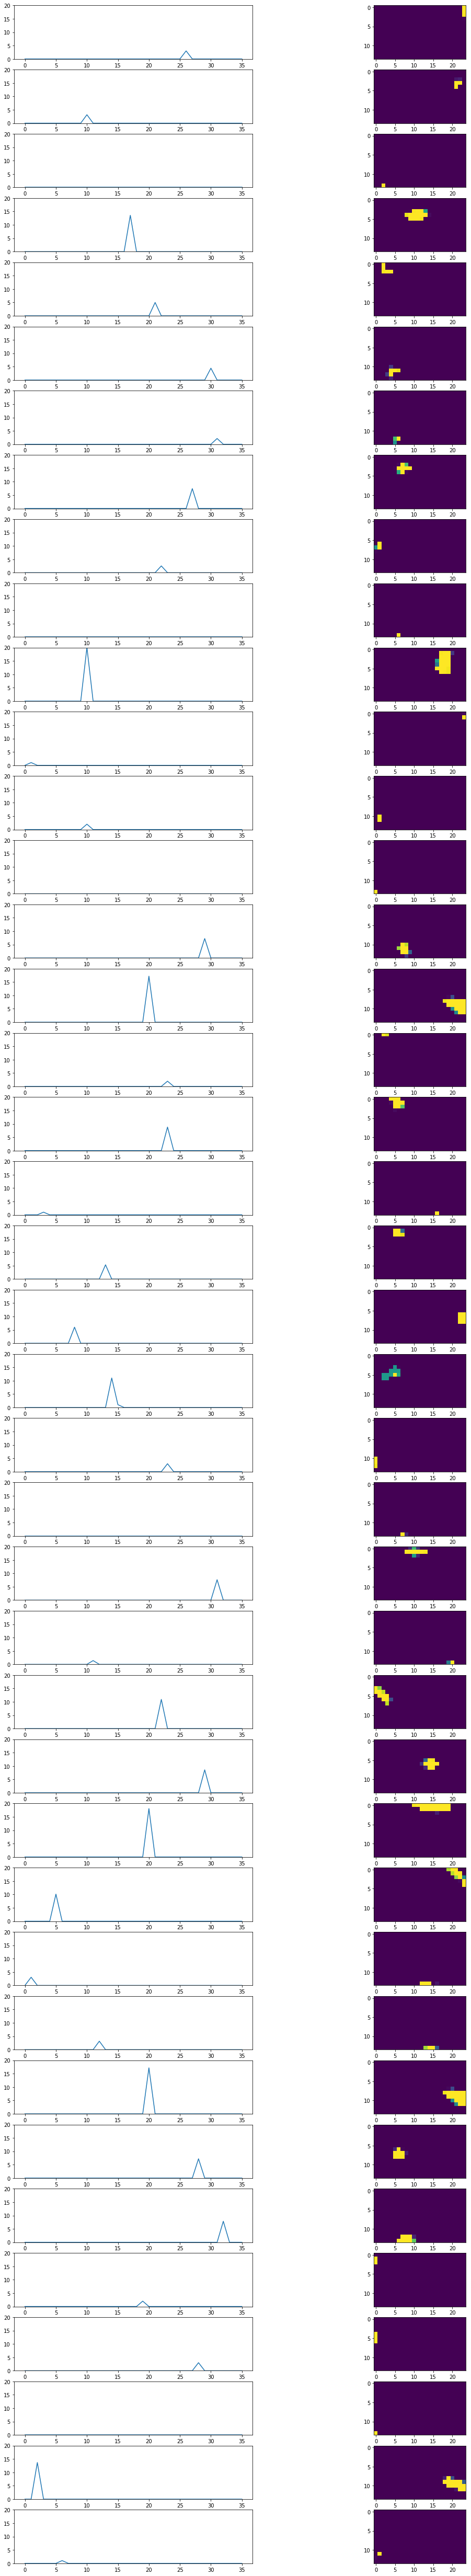

In [68]:
fig, axs = plt.subplots(40, 2, figsize=(18, 90))
rnd_head_cell = np.random.choice(head_cell_size, 40)
idx_counter = 0
for head_cell_idx in rnd_head_cell:
    axs[idx_counter][0].plot(np.abs(head_map_4_head_cell[:, head_cell_idx]))
    axs[idx_counter][0].set_ylim(0, 20)
#     min_val = min(head_map_4_head_cell[:, example_i])
#     max_val = max(head_map_4_head_cell[:, example_i])
#     axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[idx_counter][1].imshow(np.abs(place_map_4_head_cell[:, :, head_cell_idx]))
    idx_counter += 1
plt.show()

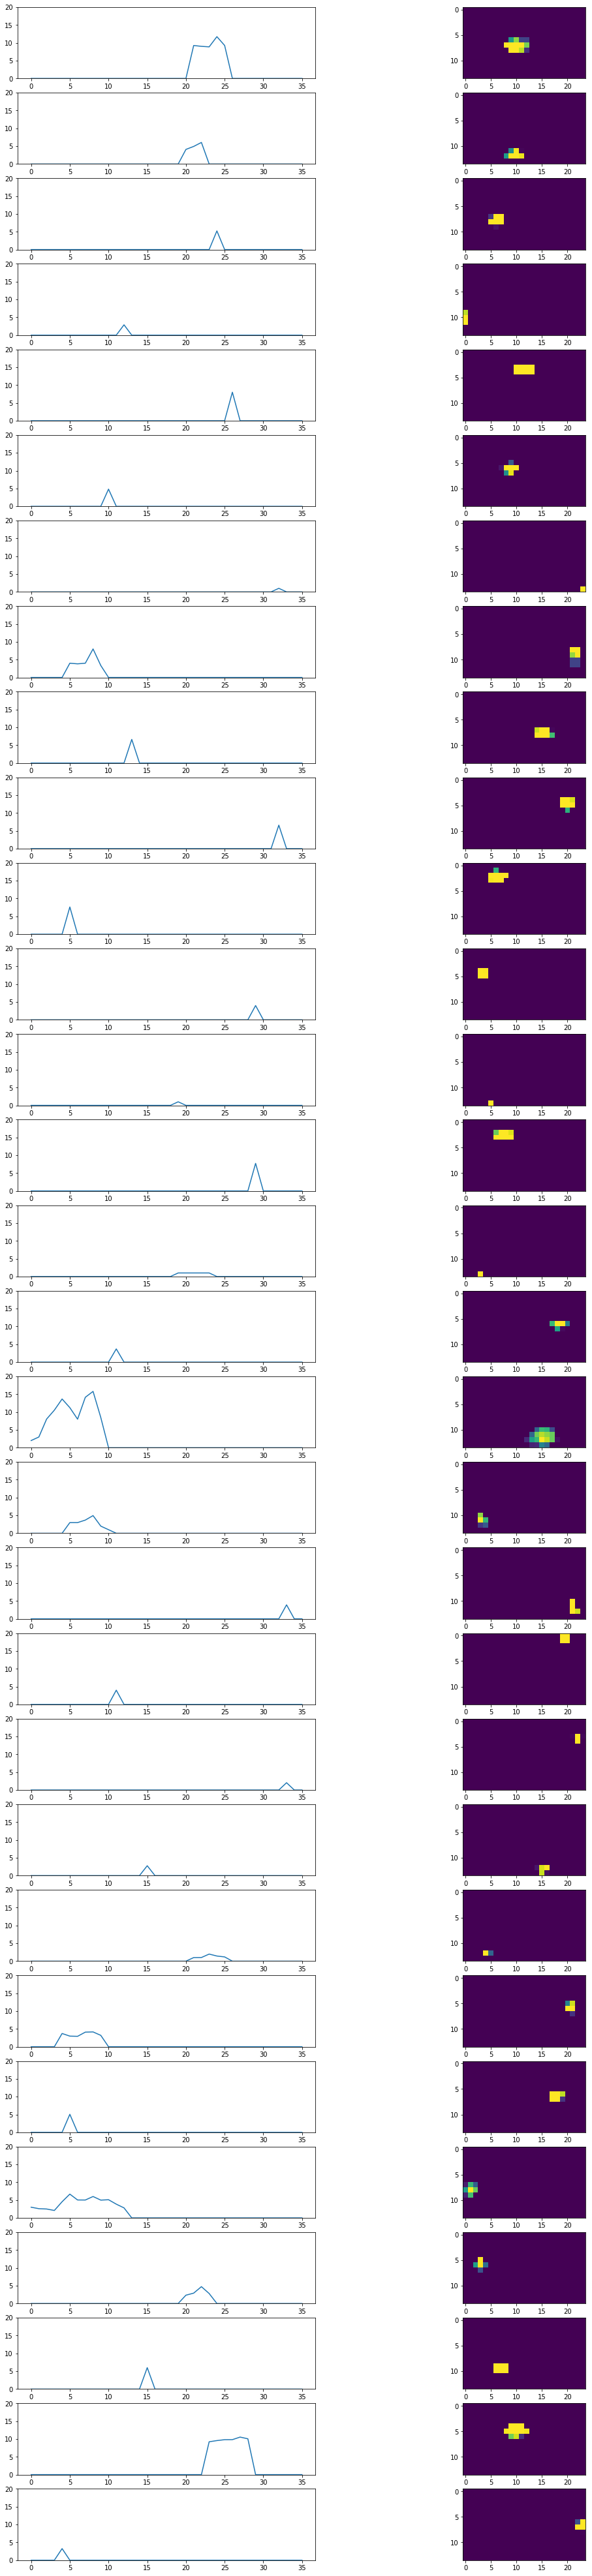

In [70]:
fig, axs = plt.subplots(30, 2, figsize=(18, 72))
rnd_place_cell = np.random.choice(place_cell_size, 30)
idx_counter = 0
for place_cell_idx in rnd_place_cell:
    axs[idx_counter][0].plot(np.abs(head_map_4_place_cell[:, place_cell_idx]))
    axs[idx_counter][0].set_ylim(0, 20)
#     min_val = min(head_map_4_head_cell[:, example_i])
#     max_val = max(head_map_4_head_cell[:, example_i])
#     axs[example_i][0].set_title('min = ' + str(min_val) + ' max = ' + str(max_val) + '\nDifferent = ' + str(max_val-min_val) + '\n...')
    axs[idx_counter][1].imshow(np.abs(place_map_4_place_cell[:, :, place_cell_idx]))
    idx_counter += 1
plt.show()